In [1]:
import numpy as np

## The Godunov Method (PCM) method with HLL Riemann Solver fluxes in 1D
### Hydrodynamics Recap
We want to solve the equations of ideal hydrodynamics in one dimension given by
\begin{align*}
  \frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}\left( \rho v \right) & =  0\;, \\
  \frac{\partial \left(\rho v_i\right)}{\partial t}  + \frac{\partial}{\partial x}\left(\rho v^2  + P \right) & = 0,\\%\quad{\color{lightgray}\left(=\,\,-\frac{\partial P_{ij}}{\partial x_j} + \rho F_i\right)}\\
  \frac{\partial E}{\partial t} + \frac{\partial}{\partial x}\left((E+P) v \right) & = 0\;.
  \end{align*}
where $\rho$ is the density, $v$ is the velocity, $P$ is the pressure, and $E$ is the total energy density, and we assemble them into a vector of conserved variables $\boldsymbol{U} = \left(\rho,\rho v, E\right)^T$. The fluxes are given by
\begin{align*}
  \boldsymbol{F}(\boldsymbol{U}) = \left( \rho v, \rho v^2 + P, (E+P)v \right)^T\;.
\end{align*}
The equations are closed using the equation of state for an ideal gas, which relates the pressure to the density and internal energy. The equation of state is given by
\begin{align*}
  P = (\gamma - 1) \left( E - \frac{1}{2} \rho v^2 \right)\;.
\end{align*}
Finally, the (adiabatic) sound speed is given by
$$
c = \sqrt{\left.\frac{\partial P}{\partial \rho}\right|_{\text{adiabatic}}} = \sqrt{\frac{\gamma P}{\rho}}\;.
$$

### The Godunov Method
This notebook implements the Godunov (Goduonov 1959) method using piecewise constant approximation for the interface states. As explained in detail in the lecture notes, the Godunov method is a finite volume method that uses the solution of the Riemann problem at each interface to compute the fluxes and then update the solution using a forward Euler step, i.e.
\begin{align*}
\left<\boldsymbol{U} \right>_i^{n+1} = \left<\boldsymbol{U} \right>_i^{n} - \frac{\Delta t}{\Delta x}\,\left( \boldsymbol{F}_{i+1/2}^n - \boldsymbol{F}_{i-1/2}^n\right)
\end{align*}
where $\Delta t$ is the time step. 

### The HLL approximate Riemann solver
The interface fluxes can be computed using the HLL (Harten-Lax-van Leer) approximate Riemann solver. The HLL flux is given by
\begin{align*}
  \boldsymbol{F}_{\rm HLL}(\boldsymbol{U}_L,\boldsymbol{U}_R)  = \frac{1}{2}\left(\boldsymbol{F}(\boldsymbol{U}_L) + \boldsymbol{F}(\boldsymbol{U}_R)\right) - \frac{S_\ast}{2} \left( \boldsymbol{U}_R - \boldsymbol{U}_L \right)\;,
\end{align*}
where the wave speed $S_\ast$ is approximated by
\begin{align*}
  S_\ast = \max\left(S_L, S_R\right)\;,
\end{align*}
where $S_L = |v_L| +c_L$ and $S_R = |v_R| +c_R$ are the magnitudes of the wave speeds of the left and right states, respectively. 

### Some helper functions to compute hydrodynamic quantities

In [2]:

def prim_to_cons(Q, gamma ):
    """
    Return an array of conserved hydro variables given an array of primitive variables
    @param Q : primitive variables (Nx3: rho, v, P)
    @return U: conserved variables (Nx3: rho, rhov, E)
    """
    U = np.zeros_like(Q)
    U[:,0] = Q[:,0]
    U[:,1] = Q[:,0] * Q[:,1]
    U[:,2] = Q[:,2]/(gamma-1) + 0.5 * Q[:,0] * Q[:,1]**2
    return U

def cons_to_prim(U, gamma ):
    """
    Return an array of primitive hydro variables given an array of conserved variables
    @return Q : primitive variables (Nx3: rho, v, P)
    @param U: conserved variables (Nx3: rho, rhov, E)
    """
    Q = np.zeros_like(U)
    Q[:,0] = U[:,0]
    Q[:,1] = U[:,1]/U[:,0]
    Q[:,2] = (gamma-1)*(U[:,2] - 0.5 *U[...,1]**2/U[...,0])
    return Q

def get_flux_from_U( U, gamma ):
    """
    Compute the flux vector from the conserved variables.
    @param U: Conserved variables (Nx3: rho, rhov, E)
    @param gamma: Adiabatic index
    @return F: Flux vector (Nx3: rho*v, rhov*v + P, (E+P)*v)
    """
    F = np.zeros_like(U)
    P = (gamma-1) * (U[:,2] - 0.5 * U[:,1]**2 / U[:,0])
    v = U[:,1] / U[:,0]
    F[:,0] = U[:,0] * v
    F[:,1] = U[:,1] * v + P
    F[:,2] = (U[:,2]+P) * v
    return F

def get_cs_and_v_from_U( U, gamma ):
    """
    Compute the sound speed and velocity from conserved variables.
    @param U: Conserved variables (Nx3: rho, rhov, E)
    @param gamma: Adiabatic index
    @return cs: Sound speed
    @return v: Velocity
    """
    v = U[:,1] / U[:,0]
    cs = np.sqrt( gamma*(gamma-1)*(U[:,2]/U[:,0]-0.5*v**2) )
    return cs, v

### Compute an update using the HLL fluxes

In [3]:

def get_conservative_update( U, dx, gamma, CFLfac ):
    """
    Compute the conservative update vector and the maximum allowed time step. Assumes periodic BCs.
    This function uses the HLL (Harten-Lax-van Leer) Riemann solver to compute the fluxes.

    Parameters:
    U (numpy.ndarray): Conserved variables (Nx3: rho, rhov, E).
    dx (float): Spatial resolution (cell width).
    gamma (float): Adiabatic index.
    CFLfac (float): CFL factor for time step calculation.

    Returns:
    dU (numpy.ndarray): Update vector for conserved variables (Nx3).
    dtmax (float): Maximum allowed time step based on CFL condition.
    """
    # compute the maximal allowed time step
    cs,v = get_cs_and_v_from_U( U, gamma )
    dtmax = CFLfac * dx / np.max( (np.abs(v)+np.abs(cs)).flatten() )

    # compute left and right state (piecewise constant approx.)
    # assume periodic BCs here, we'll fix this later in case we need
    # to use non-periodic BCs
    Uleft = U                     # U_L = U_i
    Uright = np.roll(U,-1,axis=0) # U_R = U_{i+1}

    # compute left and right flux from left and right states
    # assume periodic BCs here
    Fleft = get_flux_from_U( Uleft, gamma )   # Fleft = F( U_L )
    Fright = get_flux_from_U( Uright, gamma ) # Fright = F( U_R )

    # compute maximum signal speeds
    Sleft = np.abs(v) + np.abs(cs)
    Sright = np.roll(Sleft,-1)
    Sstar = np.max((Sleft,Sright))

    # compute HLL interface flux
    FHLL = np.zeros_like(U)
    for i in range(3): # loop over conserved variables
        FHLL[:,i] = 0.5*(Fleft[:,i]+Fright[:,i])-0.5 * Sstar * (Uright[:,i]-Uleft[:,i])

    # compute net flux in and out of cell due to left and right boundary
    dU = -( FHLL - np.roll(FHLL,+1,axis=0)) / dx

    return dU, dtmax

### Solver main driver method

In [4]:
def solve_hydro1D( Q_ini, tend, gamma = 5/3, CFLfac = 0.95):
    """
    Solve the 1D hydrodynamics equations using the Godunov method with the HLL Riemann solver.

    Parameters:
    Q_ini (numpy.ndarray): Initial conditions for the primitive variables (Nx3: rho, v, P).
    tend (float): End time for the simulation.
    gamma (float, optional): Adiabatic exponent. Default is 5/3.
    CFLfac (float, optional): CFL factor for time step calculation. Default is 0.95.

    Returns:
    numpy.ndarray: Final primitive variables (Nx3: rho, v, P) at time `tend`.
    """
    
    N = Q_ini.shape[0]
    dx = 1/N
    U = prim_to_cons(Q_ini, gamma) # convert to conserved variables

    t = 0.0 # time counter
    step = 0 # step counter
    exceeded = False
    while t<tend:
        # compute the update vector for the primitive variables
        dU, dtmax = get_conservative_update(U, dx, gamma, CFLfac)

        # we use constant Dirichlet BCs, so we set the first and last flux to zero
        dU[0,:] = 0
        dU[-1,:] = 0
        
        # compute the time step we will use for this step
        dt = np.min((CFLfac*dtmax, tend-t))
            
        # actually perform the update
        U += dt*dU
        t += dt
        step += 1
        print('Step %i, t = %.2f, dt = %.2f' % (step, t, dt), end='\r')

    print('\n Done in %i steps'%step)
    return cons_to_prim(U, gamma) # return primitive variables

### Set up initial conditions

In [32]:
# define initial conditions for the Sod shock tube
Np = 256
rho_L = 1.0
rho_R = 0.125
v_L = 0.0
v_R = 0.0
P_L = 1.0
P_R = 0.1
t_end = 0.25

x = np.linspace(0,1,Np)
Q_ini = np.zeros((x.shape[0],3))
Q_ini[:,0] = np.where(x<0.5, rho_L, rho_R) # density
Q_ini[:,1] = np.where(x<0.5, v_L, v_R) # velocity
Q_ini[:,2] = np.where(x<0.5, P_L, P_R ) # pressure

### Compute the solution using the Godunov method

In [33]:
# Compute the solution
Q = solve_hydro1D( Q_ini, t_end, gamma=1.4, CFLfac=0.95)

Step 154, t = 0.25, dt = 0.00
 Done in 154 steps


### Compute the solution using the exact Riemann solver

In [34]:
import riemann_exact as riemann

sol = riemann.solve_riemann_exact( left_state=(rho_L, v_L, P_L), right_state=(rho_R, v_R, P_R), gamma=1.4, t=t_end, npts = 1000)

### Plot the solutions

Text(0.5, 0, 'x')

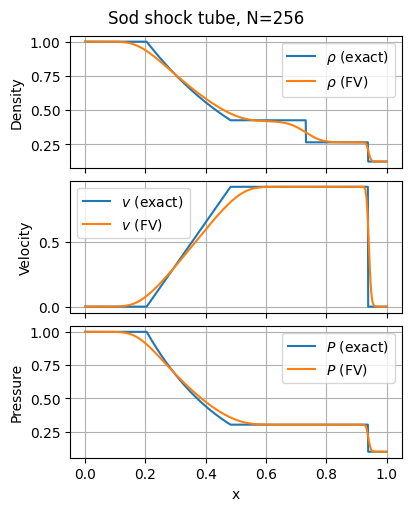

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(4, 5), sharex=True, layout='constrained' )

ax[0].plot(sol['x'], sol['rho'], '-', label='$\\rho$ (exact)')
ax[0].plot(x, Q[:,0], '-', label='$\\rho$ (FV)')
ax[0].set_ylabel('Density')

ax[1].plot(sol['x'], sol['v'], '-', label='$v$ (exact)')
ax[1].plot(x, Q[:,1], '-', label='$v$ (FV)')
ax[1].set_ylabel('Velocity')

ax[2].plot(sol['x'], sol['P'], '-', label='$P$ (exact)')
ax[2].plot(x, Q[:,2], '-', label='$P$ (FV)')
ax[2].set_ylabel('Pressure')

for a in ax:
    a.legend()
    a.grid()
plt.suptitle(f'Sod shock tube, N={Np}')
ax[-1].set_xlabel('x')